
[可在 Warp 内核中调用的内置函数的完整列表](https://nvda.org.cn/warp/modules/functions.html)

[内置数据类型](https://nvda.org.cn/warp/modules/runtime.html#id3)



In [1]:
from typing import Callable

In [2]:
import warp as wp
wp.init()

Warp 1.8.1 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "Intel64 Family 6 Model 151 Stepping 2, GenuineIntel"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     C:\Users\hy-wu.DESKTOP-G355NC5\AppData\Local\NVIDIA\warp\Cache\1.8.1


In [ ]:
import warp as wp

@wp.kernel
def simple_kernel(a: wp.array(dtype=wp.vec3),
                  b: wp.array(dtype=wp.vec3),
                  c: wp.array(dtype=float)):

    # get thread index
    tid = wp.tid()

    # load two vec3s
    x = a[tid]
    y = b[tid]

    # compute the dot product between vectors
    r = wp.dot(x, y)

    # write result back to memory
    c[tid] = r

In [4]:
import numpy as np
n = 1000

In [5]:
# 可以使用 1D、2D、3D 或 4D 的线程网格启动内核。要启动 2D 线程网格来处理 1024x1024 图像，我们可以编写
@wp.kernel
def compute_image(pixel_data: wp.array2d(dtype=wp.vec3)):
    # get thread index
    i, j = wp.tid()
# Use NumPy to generate random values, then transfer to Warp array
img_np = np.random.rand(1024, 1024, 3).astype(np.float32)
img = wp.from_numpy(img_np, dtype=wp.vec3, device="cuda")
wp.launch(kernel=compute_image, dim=(1024, 1024), inputs=[img], device="cuda")

Module __main__ 4133c14 load on device 'cuda:0' took 1.40 ms  (cached)


In [6]:
# allocate an uninitialized array of vec3s
v = wp.empty(shape=n, dtype=wp.vec3, device="cuda")
# allocate a zero-initialized array of quaternions
q = wp.zeros(shape=n, dtype=wp.quat, device="cuda")
# allocate and initialize an array from a NumPy array
# will be automatically transferred to the specified device
a = np.ones((10, 3), dtype=np.float32)
v = wp.from_numpy(a, dtype=wp.vec3, device="cuda")
# 无法在 Warp 内核中创建数组。

# bring data from device back to host
view = v.numpy()

In [7]:
# 支持最多四个维度的数组。当键入内核参数时，别名 wp.array2d、wp.array3d、wp.array4d 很有用
@wp.kernel
def make_field(field: wp.array3d(dtype=float), center: wp.vec3, radius: float):
    i, j, k = wp.tid()
    p = wp.vec3(float(i), float(j), float(k))
    d = wp.length(p - center) - radius
    field[i, j, k] = d

默认情况下，从外部数据（例如：NumPy、列表、元组）初始化的 Warp 数组将在指定的设备的新内存中创建数据的副本。但是，如果输入是连续的并且在同一设备上，则可以使用数组构造函数的 copy=False 参数来使数组别名外部内存。有关与外部框架共享内存的更多详细信息，请参阅[互操作性](https://nvda.org.cn/warp/modules/interoperability.html)部分。

In [8]:
# 用户函数
# 内核可以调用在同一模块中定义的用户函数，也可以调用在不同模块中定义的用户函数。用户函数的返回类型提示是可选的。
@wp.func
def square(x: float):
    return x*x
# 在 Warp 内核中可以做的任何事情也可以在用户函数中完成，但 wp.tid()除外。如果需要，可以通过用户函数的参数传入线程索引。
# 函数可以接受数组和结构作为输入
@wp.func
def lookup(foos: wp.array(dtype=wp.uint32), index: int):
    return foos[index]
# 也可以返回多个值
@wp.func
def multi_valued_func(a: wp.float32, b: wp.float32):
    return a + b, a - b, a * b, a / b
@wp.kernel
def test_multi_valued_kernel(test_data1: wp.array(dtype=wp.float32), test_data2: wp.array(dtype=wp.float32)):
    tid = wp.tid()
    d1, d2 = test_data1[tid], test_data2[tid]
    a, b, c, d = multi_valued_func(d1, d2)
# 也可以重载
@wp.func
def custom(x: int):
    return x + 1
@wp.func
def custom(x: float):
    return x + 1.0
@wp.func
def custom(x: wp.vec3):
    return x + wp.vec3(1.0, 0.0, 0.0)

有关在用户函数签名中使用 typing.Any 的详细信息，请参阅[泛型函数](https://nvda.org.cn/warp/modules/generics.html#generic-functions)。有关如何定义自定义梯度函数、自定义重放函数和自定义原生函数的详细信息，请参阅[可微性](https://nvda.org.cn/warp/modules/differentiability.html)。

In [9]:
# 用户结构
@wp.struct
class MyStruct:
    pos: wp.vec3
    vel: wp.vec3
    active: int
    indices: wp.array(dtype=int)
# 与内核参数一样，结构的每个属性都必须在类定义时具有有效的类型提示。
# 结构可以用作 wp.arrays 的 dtype，并且可以直接作为参数传递给内核。有关结构的更多详细信息，请参阅结构参考。

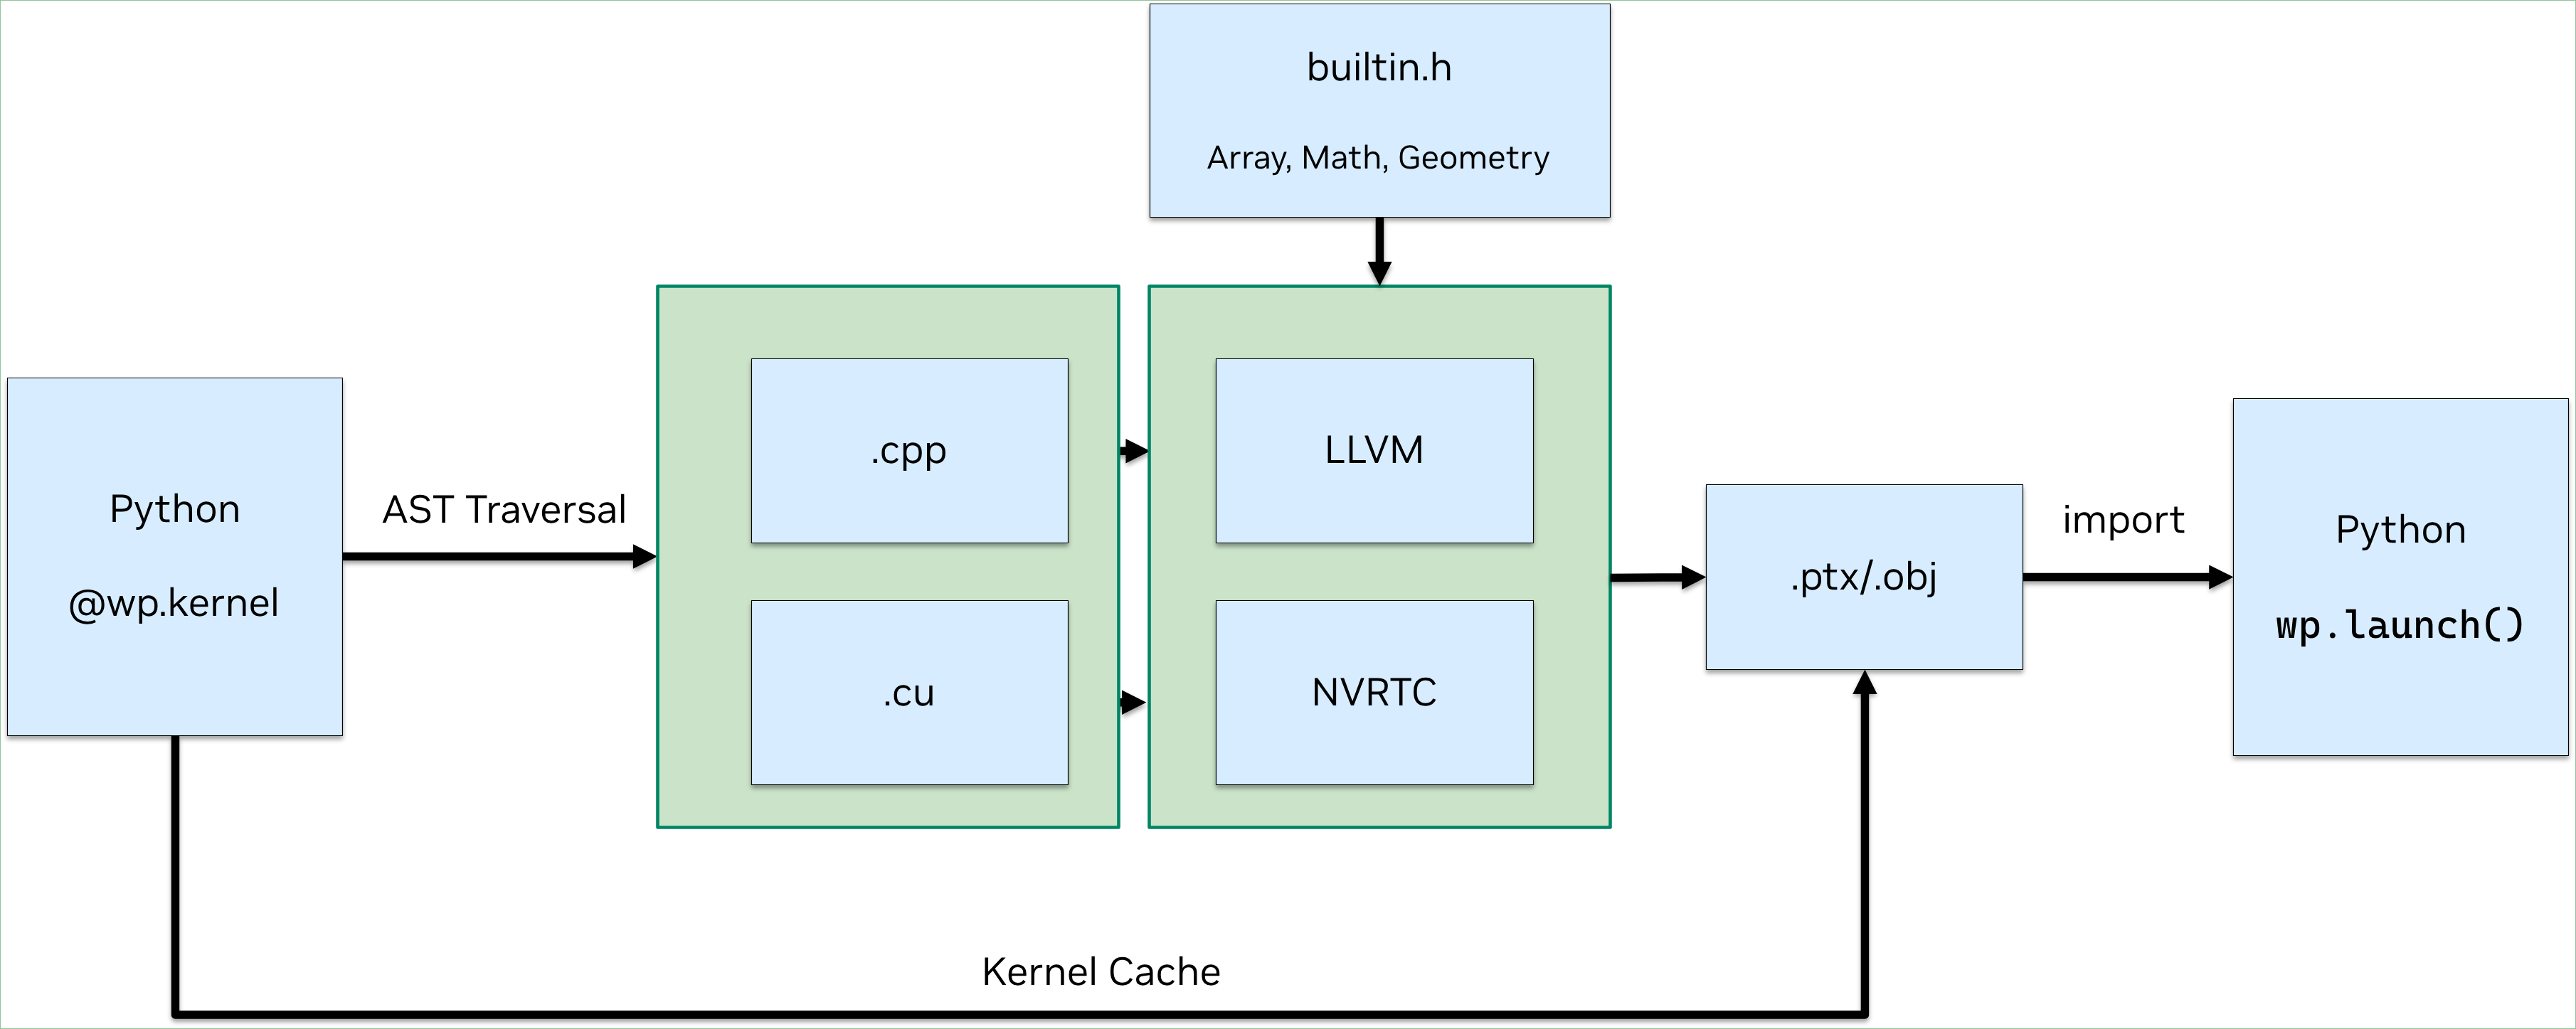
有关更多信息，请参阅[代码生成](https://nvda.org.cn/warp/codegen.html)部分。

Warp 支持许多类似于高级着色语言的内置数学类型，例如 `vec2, vec3, vec4, mat22, mat33, mat44, quat, array`。 所有内置类型都具有值语义，因此诸如 `a = b` 之类的表达式会生成变量 `b` 的副本，而不是引用。

在 Warp 中，所有变量都必须是类型化的。类型从源表达式和使用 Python 类型扩展的函数签名推断。所有内核参数都必须使用适当的类型进行注释。可以使用 `typing.Any` 代替出现在函数签名中的具体类型。有关更多信息，请参见[泛型](https://nvda.org.cn/warp/modules/generics.html)文档。

In [10]:
@wp.kernel
def simple_kernel(a: wp.array(dtype=wp.vec3),
                  b: wp.array(dtype=wp.vec3),
                  c: float):
    pass

from typing import Any
@wp.kernel
def generic_kernel(a: wp.array(dtype=Any),
                   b: wp.array(dtype=Any),
                   c: Any):
    pass

# 不支持元组初始化，而是应显式键入变量
# invalid
a = (1.0, 2.0, 3.0)
# valid
a = wp.vec3(1.0, 2.0, 3.0)

有关 Warp 限制和不支持的功能的列表，请参见[限制](https://nvda.org.cn/warp/limitations.html)。

In [1]:
import warp as wp

@wp.kernel
def kernel_func(x: wp.array(dtype=float), y: wp.array(dtype=float)):
    tid = wp.tid()
    y[tid] = x[tid] ** 2.0 + 3.0 * x[tid] + 1.0

x = wp.array([1.0, 2.0, 3.0], dtype=float, requires_grad=True)
y = wp.zeros_like(x)

tape = wp.Tape()
with tape:
    wp.launch(kernel_func, x.shape, inputs=[x], outputs=[y])
tape.backward(grads={y: wp.ones_like(x)})

print(x.grad)


Warp 1.8.1 initialized:
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "Intel64 Family 6 Model 151 Stepping 2, GenuineIntel"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
   Kernel cache:
     C:\Users\hy-wu.DESKTOP-G355NC5\AppData\Local\NVIDIA\warp\Cache\1.8.1
Module __main__ 5712c0b load on device 'cuda:0' took 399.23 ms  (compiled)
[5. 7. 9.]


In [3]:
y.numpy()

array([ 5., 11., 19.], dtype=float32)

In [22]:
a.numpy()

array([[ 1.47627104, -1.83096678, -0.77034131, ...,  0.82936698,
         1.59746893, -1.68586924],
       [ 0.33070117,  1.26881676, -1.46921007, ...,  0.04173749,
        -0.14375551, -0.61637364],
       [ 2.0940415 , -0.13147181, -0.0818613 , ..., -0.38244553,
         1.71973436, -2.41276984],
       ...,
       [ 0.90562294, -1.13892612, -1.407668  , ..., -0.76201825,
         0.10565528,  0.56343175],
       [-0.50514851, -1.06361675,  0.75499246, ..., -0.7258888 ,
         0.78666508, -0.72715265],
       [-0.04656621, -0.99918629,  0.45707439, ...,  1.41253318,
         1.50396572,  0.36416169]], shape=(64, 32))